In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [2]:
# 2. Load and Clean Dataset
df = pd.read_csv("tweets _6.csv", encoding='ISO-8859-1')

In [3]:
df.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [4]:
df['sentiment'] = df['sentiment'].astype(str)

In [5]:
df = df[['text', 'sentiment']]  # Adjust if needed

In [6]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [7]:
df['clean_text'] = df['text'].apply(clean_text)

In [8]:
# 3. Label Encoding
le = LabelEncoder()
df['encoded_sentiment'] = le.fit_transform(df['sentiment'])
num_classes = len(le.classes_)

In [9]:
# 4. Tokenize and Pad Sequences
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
padded = pad_sequences(sequences, maxlen=100, padding='post')

In [10]:
# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    padded, df['encoded_sentiment'], test_size=0.2, random_state=42)

y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [11]:
# 6. Build RNN Model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_length=100))
model.add(SimpleRNN(64))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
# 7. Train the Model
history = model.fit(X_train, y_train_cat, epochs=5, batch_size=64, validation_data=(X_test, y_test_cat))

Epoch 1/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4078 - loss: 1.2292 - val_accuracy: 0.4611 - val_loss: 1.2618
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5213 - loss: 0.9402 - val_accuracy: 0.5441 - val_loss: 0.8072
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5433 - loss: 0.8168 - val_accuracy: 0.5431 - val_loss: 0.8084
Epoch 4/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4968 - loss: 1.1434 - val_accuracy: 0.2451 - val_loss: 1.7272
Epoch 5/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3838 - loss: 1.2960 - val_accuracy: 0.5213 - val_loss: 0.8337


In [14]:
# 8. Evaluation
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy*100:.2f}%")

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5169 - loss: 0.8348
Test Accuracy: 52.13%


In [15]:
# 9. Classification Report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

         nan       0.99      1.00      1.00       258
    negative       0.36      0.05      0.09       226
     neutral       0.38      0.52      0.44       268
    positive       0.30      0.44      0.36       211

    accuracy                           0.52       963
   macro avg       0.51      0.50      0.47       963
weighted avg       0.52      0.52      0.49       963



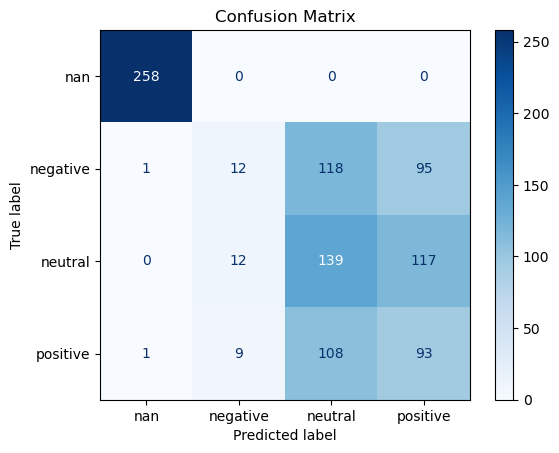

In [16]:
# 10. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

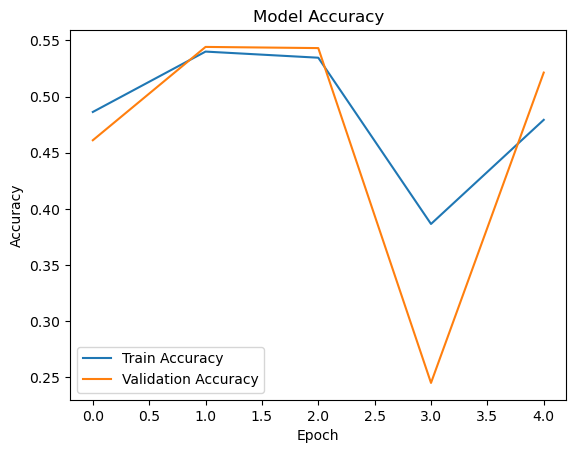

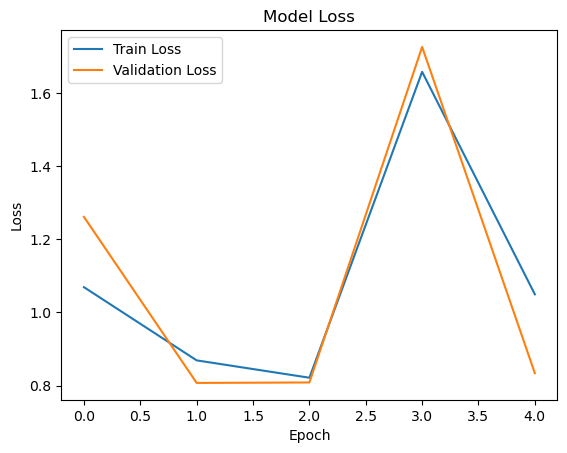

In [17]:
# 11. Accuracy & Loss Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


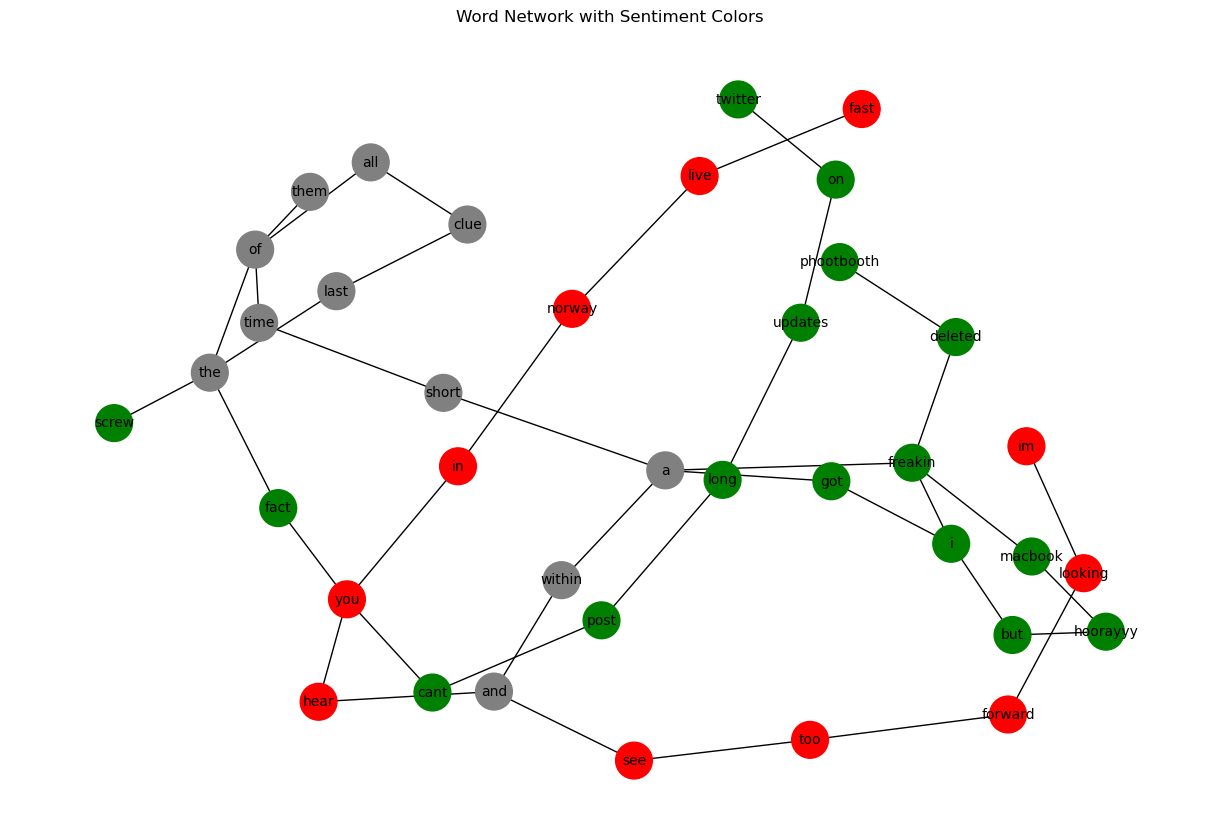

In [43]:
# 12. Network Graph Visualization of Sentiment
sample_tweets = df['clean_text'].sample(5, random_state=42)
sample_sequences = tokenizer.texts_to_sequences(sample_tweets)
sample_padded = pad_sequences(sample_sequences, maxlen=100, padding='post')
sample_predictions = model.predict(sample_padded)
predicted_labels = np.argmax(sample_predictions, axis=1)
label_names = le.inverse_transform(predicted_labels)

G = nx.Graph()

for i, tweet in enumerate(sample_tweets):
    words = tweet.split()
    sentiment = label_names[i]
    for j in range(len(words) - 1):
        G.add_edge(words[j], words[j + 1])
        G.nodes[words[j]]['sentiment'] = sentiment
        G.nodes[words[j + 1]]['sentiment'] = sentiment

color_map = {
    'positive': 'green',
    'negative': 'red',
    'neutral': 'gray'
}
node_colors = []
for node in G.nodes():
    sentiment = G.nodes[node].get('sentiment', 'neutral')
    node_colors.append(color_map.get(sentiment, 'gray'))

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=700, font_size=10, edge_color='black')
plt.title("Word Network with Sentiment Colors")
plt.show()